# Single Cell Analysis - PCA Pipeline

### Input(s): 
* AnnData file

**Pre-Processing:** 
* Make var names unique -- specific to file? 
* Filter out cells with few genes - perforated cells? 
* Filter out genes with few cells - too rare? 

**PCA:** 
* Run PCA
* Plot PCA results
* Identify what the different anndata files are 
* Save files to CSV
* Determine Number of Components Needed to Hit Desired Explained Variance Thresholds

### Output(s):
* CSV files for PCA data (4 files) -- I didn't code them all but there are 4 files that we could capture 
* Number of Components for desired explained variance thresholds -- I didn't actually export these numbers to files, but we could.  


## Set-up

In [1]:
# Imports
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Set ScanPy settings: 
# Set settings 
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [4]:
# Set up results storage
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
# Read file (.mtx)
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


## Pre-Processing

In [6]:
# Process data 
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [7]:
# Filter genes - defaults from scanpy tutorial 

# Removes cells with less than 200 genes 
sc.pp.filter_cells(adata, min_genes=200)

# Removes genes expressed in fewer than 3 cells 
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detectedin less than 3 cells


## PCA

### Note: We will need to choose the method: 
    
   ``'arpack'`` - for the ARPACK wrapper in SciPy (:func:`~scipy.sparse.linalg.svds`) -- **Chosen in scanpy tutorial**

   ``'randomized'`` - for the randomized algorithm due to Halko (2009).

   ``'auto'`` (the default) - chooses automatically depending on the size of the problem.

In [8]:
# Computes PCA on n components (looped from 1 to n # of components)  Default is 50 
sc.tl.pca(adata, n_comps=150, svd_solver='arpack')

computing PCA with n_comps = 150
    finished (0:00:07)


In [9]:
# Save PCA results to anndata file
adata.write(results_file)

In [10]:
# Can see that PCA is now saved in anndata file as uns, obsm, and varm
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## What exactly are these graphs showing? 

#### Graph 1: 
% Variance explained by each PC independently 

#### Graph 2: 
% variance explained by the sum of components up to n components used to do PCA. Number of components refers to n_comp in the PCA function. (I think?)
https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

<Figure size 1200x400 with 0 Axes>

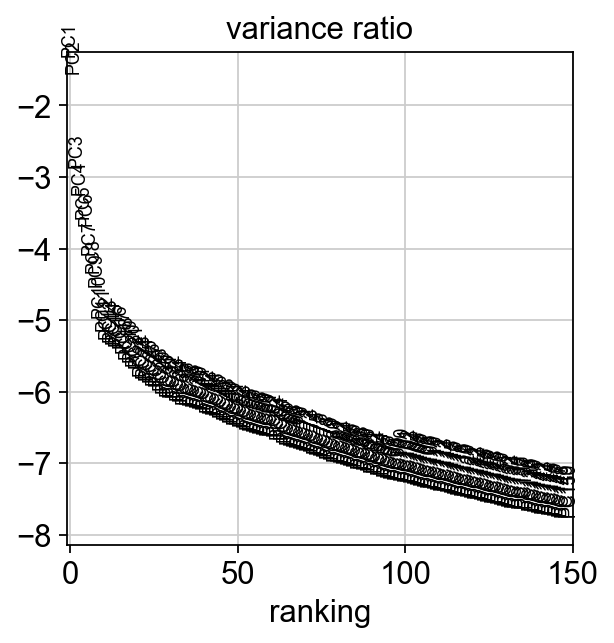

In [11]:
# Visualize the PCA 
plt.figure(figsize=(15,5))                 # Doesn't work - not sure how to change figure size of scanpy plots
sc.pl.pca_variance_ratio(adata, n_pcs = 150, log=True)

In [12]:
ratio_exp_var = adata.uns['pca']['variance_ratio']

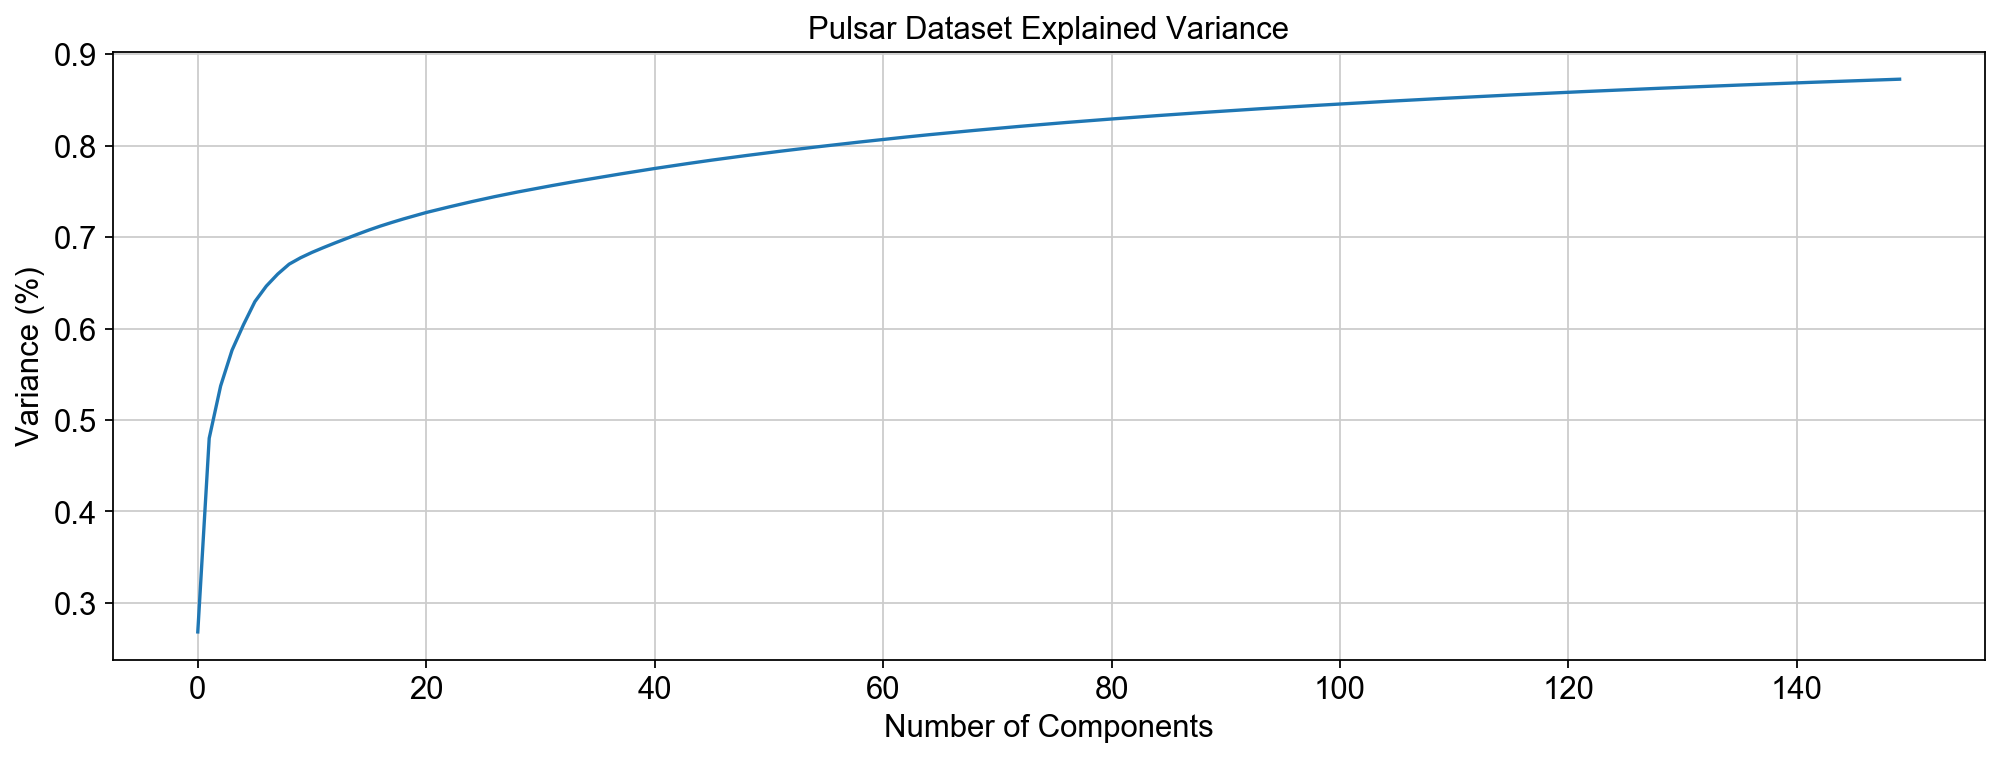

In [13]:
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(ratio_exp_var))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

## Save Data
### How do we retrieve the data out of the AnnData file?  

#### Saved in the adata file as:
* adata.varm['PCs']: The principal components containing the loadings.
* **adata.obsm['X_pca']:  PCA representation of data.                              - Cells by PC's** 
* **adata.uns['pca']['variance_ratio']: Ratio of explained variance.              - The info in the graph above** 
* adata.uns['pca']['variance']: Explained variance, equivalent to the eigenvalues of the covariance matrix.


In [14]:
# The principal components containing the loadings.
# How each original feature relates to the PCs 
print(adata.varm['PCs'])
print(adata.varm['PCs'].shape)

[[ 2.84286616e-05 -2.20139809e-05 -7.07421495e-05 ... -3.59278405e-04
  -3.50038346e-04 -7.87516241e-04]
 [ 1.75253217e-06 -4.58256125e-07  2.83645222e-05 ...  2.24315954e-06
  -2.54661951e-04  2.06818295e-04]
 [ 2.79698252e-05  5.16286273e-05 -8.12312428e-05 ... -2.99571460e-04
   6.43366366e-04 -3.75635776e-04]
 ...
 [ 6.60899459e-05 -1.90261267e-06  1.57142858e-05 ... -1.38739015e-05
  -5.78524705e-05  6.15273078e-04]
 [ 1.23091042e-04  3.21010535e-04  2.47486692e-04 ... -1.69866078e-03
  -3.37654608e-03  1.20435236e-03]
 [ 8.18571280e-05  2.58249725e-04  2.91546403e-05 ... -1.47237058e-03
   2.05839309e-03 -3.41047329e-04]]
(13714, 150)


In [15]:
# Cells (rows) x PCs (columns)
print(adata.obsm['X_pca'])
print(adata.obsm['X_pca'].shape)

[[-1.3064006e+01  3.9604553e+01  1.6049585e+00 ...  1.9154000e+00
   2.0763233e-02  2.0929022e+00]
 [ 4.8335049e+01  1.9730681e+02 -1.0306381e+01 ... -2.9277875e+00
   4.4265962e+00 -8.2372332e-01]
 [ 7.2714424e+00  7.9562889e+01  8.7014778e+01 ... -9.9528357e-02
  -1.0297019e+00 -6.7787051e-01]
 ...
 [-2.6113333e+01 -2.4414040e+01 -2.3469309e+01 ... -2.6027793e-03
  -3.5228770e-02  4.0663071e+00]
 [-6.3817230e+01 -4.7973904e+01  2.9616194e+01 ... -1.9423336e+00
  -1.1663537e+00  5.6143265e-02]
 [-3.2456547e+01  7.8955574e+00 -1.4203667e+01 ... -6.7512488e-01
  -3.0558453e+00  3.8591743e-01]]
(2700, 150)


In [16]:
adata.uns['pca']

{'variance': array([4825.75     , 3806.7622   , 1027.0624   ,  703.888    ,
         499.65115  ,  454.40884  ,  305.02136  ,  236.64684  ,
         194.89714  ,  125.34208  ,  105.473625 ,   94.26744  ,
          90.29484  ,   87.824104 ,   85.57963  ,   82.97815  ,
          77.283264 ,   71.14805  ,   68.01175  ,   64.269394 ,
          62.268032 ,   55.721203 ,   54.2008   ,   52.617573 ,
          51.743927 ,   49.376194 ,   48.630436 ,   46.21003  ,
          44.417274 ,   42.187218 ,   41.83455  ,   41.53772  ,
          40.100155 ,   39.44977  ,   37.87899  ,   37.76616  ,
          37.170357 ,   36.954544 ,   36.208958 ,   35.62994  ,
          35.430206 ,   34.022903 ,   33.24485  ,   32.95978  ,
          32.398266 ,   31.543633 ,   30.652275 ,   30.089935 ,
          29.340195 ,   28.694403 ,   28.469213 ,   27.804493 ,
          27.368305 ,   26.711685 ,   26.398073 ,   25.962833 ,
          25.525646 ,   25.334747 ,   24.954445 ,   24.558155 ,
          24.435654 ,   24.2

In [17]:
adata.uns['pca']['variance_ratio'].shape

(150,)

In [18]:
adata.uns['pca']['variance'].shape

(150,)

In [19]:
adata.X.shape

(2700, 13714)

Raw dat (adata.X) has 2700 rows (cells) by 13714 columns (genes) 

### Can we save it as a csv?

In [20]:
data = adata.obsm['X_pca']
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-13.064006,39.604553,1.604959,15.111597,-25.892981,-16.018368,-12.284206,-10.061439,-5.809294,9.470128,...,-2.399064,2.112183,-3.543139,1.156247,1.511254,3.128959,-2.055423,1.915400,0.020763,2.092902
1,48.335049,197.306808,-10.306381,-5.239503,36.738125,30.993454,-11.283892,-17.620258,10.361117,32.605453,...,-3.179463,-1.557573,3.087320,1.649820,-1.673345,-7.218343,3.944253,-2.927788,4.426596,-0.823723
2,7.271442,79.562889,87.014778,-11.336234,44.660900,-9.391830,46.015282,25.426220,-29.040440,-11.727970,...,-0.545988,1.929548,-1.033858,0.351665,4.343943,-0.797086,-2.007130,-0.099528,-1.029702,-0.677871
3,101.248085,-62.092415,1.788578,10.121469,-23.159645,19.747732,-2.927417,36.400017,-32.641140,-13.073549,...,2.469931,2.235608,-4.214557,-0.130077,-1.229805,-1.360574,-0.695994,-2.131111,2.999618,-0.445487
4,-51.232922,-89.205711,8.749825,25.339937,-11.548215,0.723611,2.129119,-8.448786,10.422194,-2.777639,...,-0.997098,-1.204047,1.569954,-1.405565,-0.637931,0.590850,-1.336690,-1.419297,2.505615,1.456226


In [21]:
df.to_csv('pbmc3k_X_pca.csv')

### How do we set thresholds on explained variance? 

In [22]:
df2 = pd.DataFrame(np.cumsum(ratio_exp_var),columns=['Explained_Variance'])
df2.sort_values(by='Explained_Variance')
df2['No_Components'] = [x for x in range(150)]
df2.tail()

,Explained_Variance,No_Components
145,0.870751,145
146,0.871193,146
147,0.871629,147
148,0.872063,148
149,0.872494,149


In [23]:
df2.describe()

,Explained_Variance,No_Components
count,150.000000,150.000000
mean,0.798344,74.500000
std,0.082419,43.445368
min,0.268368,0.000000
25%,0.769425,37.250000
50%,0.823603,74.500000
75%,0.853261,111.750000
max,0.872494,149.000000


### Function to return number of components for a given threshold

In [24]:
def choose_num_components(threshold,df): 
    for n in range(len(df)): 
        if df['Explained_Variance'][n] >= threshold: 
            result = df['No_Components'][n]
            break
    return result

In [25]:
choose_num_components(.7,df2)

14

In [26]:
choose_num_components(.8,df2)

56

### Should we be saving something different here after we choose the number of components? 

## Next: Run tSNE and UMAP with selected number of components

### Old Code/ This didn't work

Is the ratio of explained variance the same as the variance amount for component divided by the sum of all the variances? 

... does not appear to be?

In [ ]:
ratio_exp_var = adata.uns['pca']['variance_ratio']
df_ratio = pd.DataFrame(ratio_exp_var)
df_ratio.sort_values(by=0,ascending=False).head()

In [ ]:
exp_var = adata.uns['pca']['variance']
df_EV = pd.DataFrame(exp_var)
df_EV.sort_values(by=0,ascending=False).head()

In [ ]:
total_variance = df_EV[0].sum()
total_variance

In [ ]:
4825/total_variance